In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn import ensemble #ансамбли

plt.style.use('seaborn') #стиль отрисовки seaborn
%matplotlib inline

In [2]:
shoppers_data = pd.read_csv('data/online_shoppers_intention.csv')
shoppers_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [3]:
print(shoppers_data.shape)


(12330, 18)


In [4]:
shoppers_data.isna().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [5]:
dummy_data = pd.get_dummies(shoppers_data)
dummy_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [7]:
print(dummy_data.shape)


(12330, 29)


Итак, нам необходимо предсказать целевую переменную Revenue — признак покупки. Целевой признак является бинарным категориальным, то есть мы решаем задачу бинарной классификации. В первую очередь посмотрим на соотношение классов в данных:

Non-fraud transactions: 84.53%
Fraud transactions: 15.47%


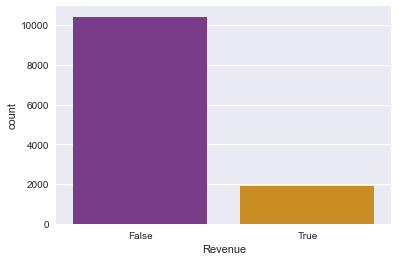

In [8]:
sns.countplot(x='Revenue', data=dummy_data, palette='CMRmap')
class_percent = dummy_data['Revenue'].value_counts(normalize=True) * 100
print('Non-fraud transactions: {:.2f}%'.format(class_percent[0]))
print('Fraud transactions: {:.2f}%'.format(class_percent[1]))

In [9]:
X, y = dummy_data.drop('Revenue', axis=1), dummy_data['Revenue']


Давайте заранее определимся, как мы будем производить контроль качества наших моделей:

Разделим выборку на тренировочную и тестовую.
Будем проводить кросс-валидацию на тренировочной выборке (то есть будем делить её на тренировочные и валидационные фолды и считать среднее значение метрики по фолдам).
Итого мы будем использовать три показателя:

значение метрики на тренировочных и валидационных фолдах кросс-валидации (по ним мы будем отслеживать переобучение модели и подбирать внешние параметры);
значение метрики на отложенной тестовой выборке (оно будет нашим контрольным показателем).
Другими словами, мы будем сочетать hold-оut- и k-fold-подходы к валидации.

In [10]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [13]:
X_test.shape

(2466, 28)

Коллеги посоветовали нам использовать случайный лес (Random Forest) для решения данной задачи. Давайте последуем их совету.

Создайте модель случайного леса. В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.

Оцените качество такой модели с помощью кросс-валидации по пяти фолдам. Так как классы несбалансированы, используйте кросс-валидатор StratifiedKFold (перемешивать выборку не нужно).

Для проведения кросс-валидации используйте функцию cross_validate(). Набор данных (параметры X, y) — тренировочная выборка (X_train, y_train). Метрика — -score.

Чему равно среднее значение метрики  на тренировочных и валидационных фолдах? Ответ округлите до двух знаков после точки-разделителя.

In [23]:
def plot_learning_curve(model, X, y, cv, scoring="f1", ax=None, title=""):
    # Вычисляем координаты для построения кривой обучения
    train_sizes, train_scores, valid_scores = model_selection.learning_curve(
        estimator=model,  # модель
        X=X,  # матрица наблюдений X
        y=y,  # вектор ответов y
        cv=cv,  # кросс-валидатор
        scoring="f1",  # метрика
    )
    # Вычисляем среднее значение по фолдам для каждого набора данных
    train_scores_mean = np.mean(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    # Если координатной плоскости не было передано, создаём новую
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))  # фигура + координатная плоскость
    # Строим кривую обучения по метрикам на тренировочных фолдах
    ax.plot(train_sizes, train_scores_mean, label="Train")
    # Строим кривую обучения по метрикам на валидационных фолдах
    ax.plot(train_sizes, valid_scores_mean, label="Valid")
    # Даём название графику и подписи осям
    ax.set_title("Learning curve: {}".format(title))
    ax.set_xlabel("Train data size")
    ax.set_ylabel("Score")
    # Устанавливаем отметки по оси абсцисс
    ax.xaxis.set_ticks(train_sizes)
    # Устанавливаем диапазон оси ординат
    ax.set_ylim(0, 1)
    # Отображаем легенду
    ax.legend()

In [14]:
from sklearn import ensemble

Train k-fold mean accuracy: 0.56
Valid k-fold mean accuracy: 0.51


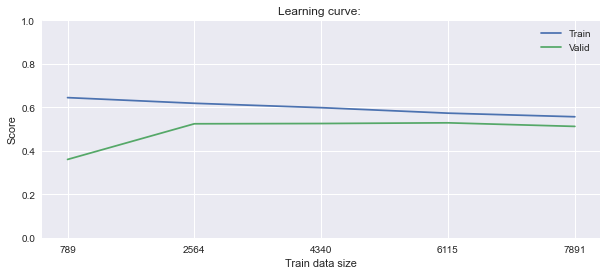

In [24]:
#Создаём объект класса RandomForestClassifier
model = ensemble.RandomForestClassifier(
    n_estimators = 200,
    min_samples_leaf = 5,
    max_depth = 5,
    random_state=42 #генератор случайных чисел
)
 
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X_train, #матрица наблюдений X
    y=y_train, #вектор ответов y
    cv=skf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))
plot_learning_curve(model,X_train, y_train, skf)

Train k-fold mean accuracy: 0.69
Valid k-fold mean accuracy: 0.62


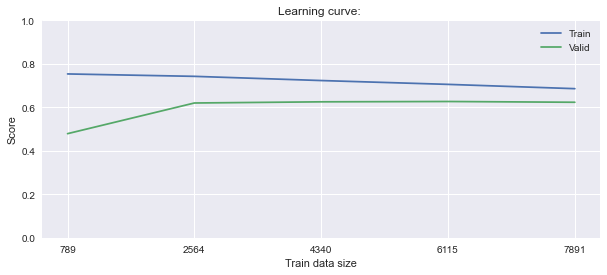

In [26]:
#Создаём объект класса RandomForestClassifier
model = ensemble.RandomForestClassifier(
    n_estimators = 200,
    min_samples_leaf = 5,
    max_depth = 7,
    random_state=42 #генератор случайных чисел
)
 
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X_train, #матрица наблюдений X
    y=y_train, #вектор ответов y
    cv=skf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))
plot_learning_curve(model,X_train, y_train, skf)

Train k-fold mean accuracy: 0.79
Valid k-fold mean accuracy: 0.65


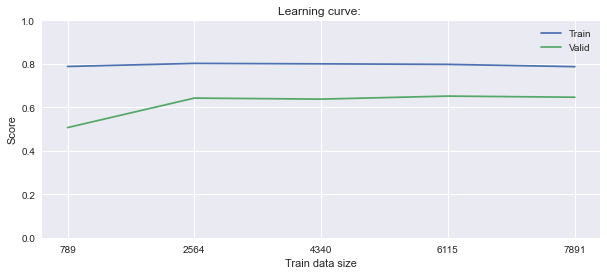

In [27]:
#Создаём объект класса RandomForestClassifier
model = ensemble.RandomForestClassifier(
    n_estimators = 200,
    min_samples_leaf = 5,
    max_depth = 12,
    random_state=42 #генератор случайных чисел
)
 
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X_train, #матрица наблюдений X
    y=y_train, #вектор ответов y
    cv=skf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))
plot_learning_curve(model,X_train, y_train, skf)

In [30]:
model = ensemble.RandomForestClassifier(
    n_estimators=200, 
    max_depth=7,
    min_samples_leaf=5,
    random_state=42
)

model.fit(X_train, y_train)
y_test_predict = model.predict(X_test)
print(metrics.classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

       False       0.91      0.98      0.94      2084
        True       0.79      0.49      0.60       382

    accuracy                           0.90      2466
   macro avg       0.85      0.73      0.77      2466
weighted avg       0.89      0.90      0.89      2466



Попробуем повысить качество распознавания посетителей, совершивших покупку. Используем метод подбора порога вероятности с помощью PR-кривой.

Порог вероятности будем подбирать с помощью кросс-валидации.

Сделайте предсказание вероятностей принадлежности к пользователям, которые совершат покупку, на кросс-валидации на пяти фолдах. Используйте метод cross_val_predict().

Для кросс-валидации используйте случайный лес с подобранной в задании 6.5 максимальной глубиной деревьев, набор данных (параметры X, y) — тренировочная выборка (X_train, y_train).

Постройте PR-кривую и отметьте на ней точку, в которой наблюдается максимум метрики  для посетителей, которые совершат покупку. Определите порог вероятности, соответствующий этой точке.

В качестве ответа приведите значение выбранного порога вероятности. Ответ округлите до двух знаков после точки-разделителя.

In [31]:
model = ensemble.RandomForestClassifier(
    n_estimators=200, 
    max_depth=7,
    min_samples_leaf=5,
    random_state=42
)

#Обучаем модель
model.fit(X_train, y_train)
#Создаём кросс-валидатор k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
#Делаем предсказание вероятностей на кросс-валидации
y_cv_proba_pred = model_selection.cross_val_predict(model, X_train, y_train, cv=skf, method='predict_proba')

In [33]:
#Выделяем столбец с вероятностями для класса 1 
y_cv_proba_pred = y_cv_proba_pred[:, 1]

In [34]:
#Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_cv_proba_pred)

print('Thresholds:', thresholds[:5])
print('Precision scores:', precision[:5])
print('Recall scores:',recall[:5])

Thresholds: [0.01034715 0.01036942 0.01039418 0.0104057  0.01040959]
Precision scores: [0.17165354 0.17156036 0.17157966 0.17159896 0.17161828]
Recall scores: [1.         0.99934469 0.99934469 0.99934469 0.99934469]


Best threshold = 0.36, F1-Score = 0.69


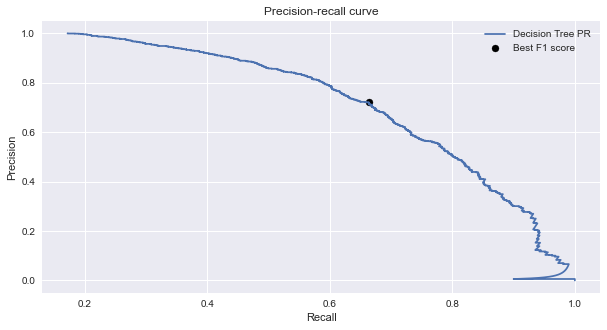

In [35]:
#Вычисляем F1-score при различных threshold
f1_scores = (2 * precision * recall) / (precision + recall)
#Определяем индекс максимума
idx = np.argmax(f1_scores)
print('Best threshold = {:.2f}, F1-Score = {:.2f}'.format(thresholds[idx], f1_scores[idx]))
 
#Строим PR-кривую
fig, ax = plt.subplots(figsize=(10, 5)) #фигура + координатная плоскость
#Строим линейный график зависимости precision от recall
ax.plot(precision, recall, label='Decision Tree PR')
#Отмечаем точку максимума F1
ax.scatter(precision[idx], recall[idx], marker='o', color='black', label='Best F1 score')
#Даём графику название и подписываем оси
ax.set_title('Precision-recall curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
#Отображаем легенду
ax.legend();

In [36]:
y_valid_pred_proba = model.predict_proba(X_test)[:, 1]
y_valid_pred = (y_valid_pred_proba > 0.36).astype('int')
#Считаем метрики
print(metrics.classification_report(y_test, y_valid_pred))

              precision    recall  f1-score   support

       False       0.94      0.93      0.94      2084
        True       0.66      0.69      0.67       382

    accuracy                           0.90      2466
   macro avg       0.80      0.81      0.81      2466
weighted avg       0.90      0.90      0.90      2466

